<a href="https://colab.research.google.com/github/TAMIDSpiyalong/Introduction-to-Machine-Learning-for-Energy/blob/main/Lecture_5a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Hands-on tutorial for DETR

In this notebook, we show-case how to:
* use the pre-trained models that we provide to make predictions
* visualize the attentions of the model to gain insights on the way it sees the images.

## Preliminaries
This section contains the boilerplate necessary for the other sections. Run it first.

In [3]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [4]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [5]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox).cpu()
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [6]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Detection - using a pre-trained model from TorchHub

In this section, we show-case how to load a model from hub, run it on a custom image, and print the result.
Here we load the simplest model (DETR-R50) for fast inference. You can swap it with any other model from the model zoo.

In [7]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 42.3MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cach

We now retrieve the image as a PIL image

In [8]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

We apply some pre-processing, run it through the model, and filter the predictions. In particular, we keep only the objects for which the class confidence is higher than 0.9 (discounting the "non-object" predictions). You can lower this threshold if you want more predictions.

In [9]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

In [10]:
probas.shape

torch.Size([100, 91])

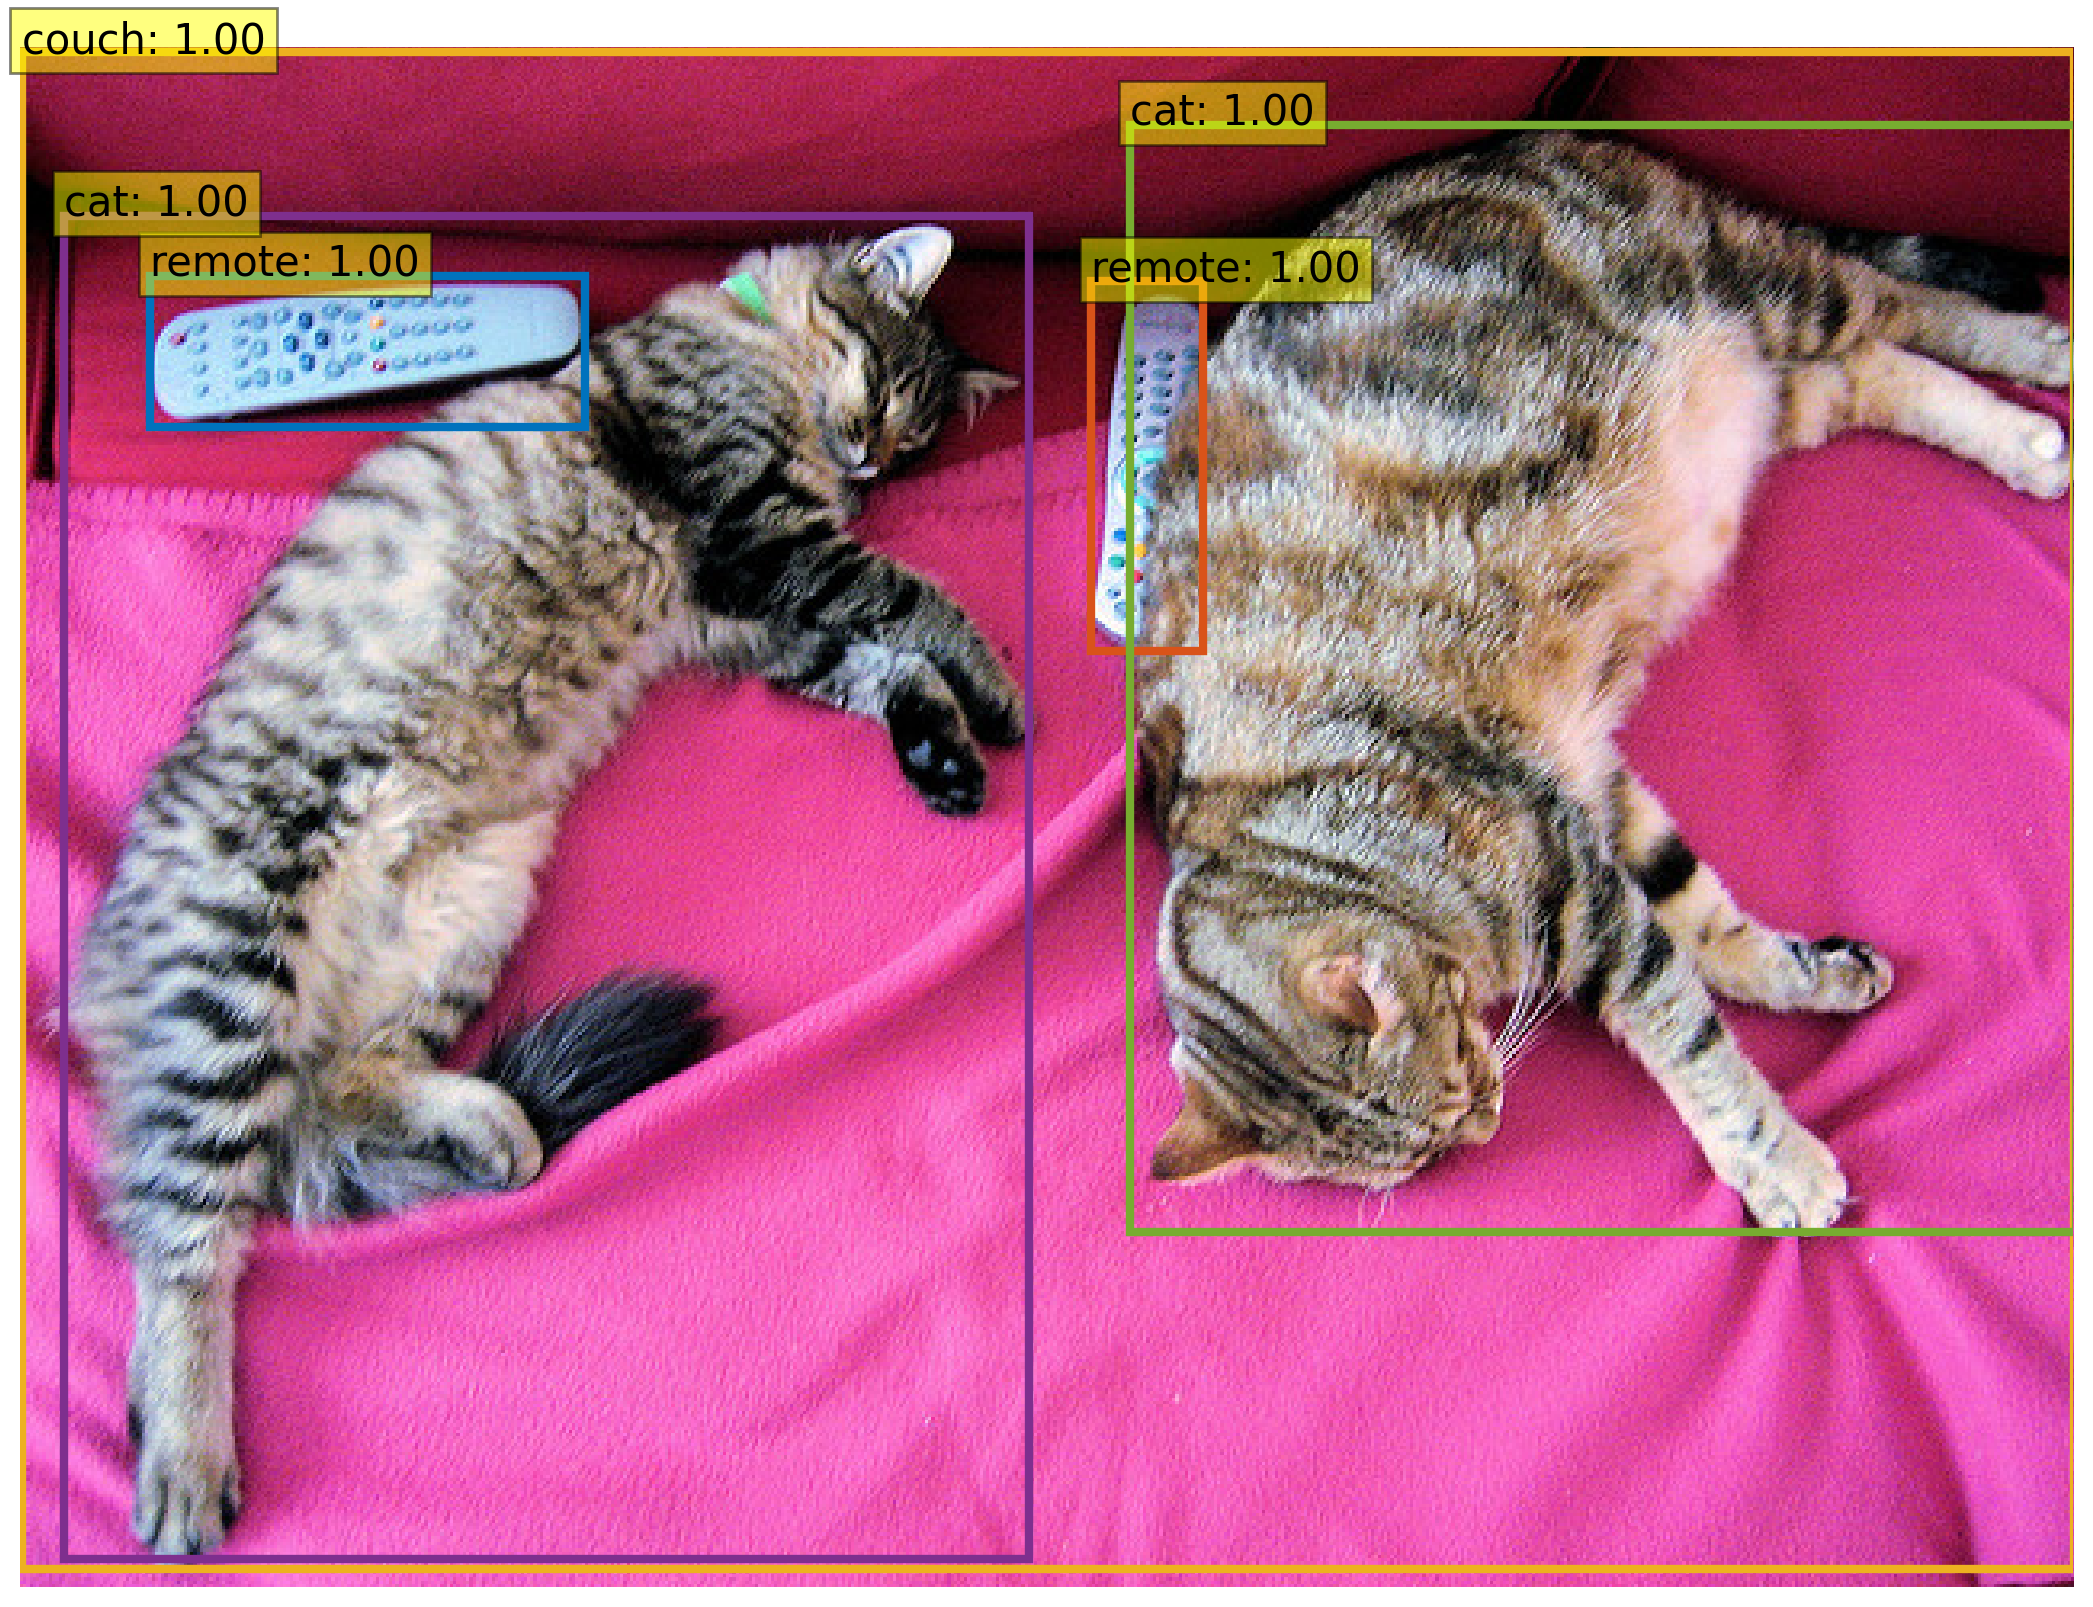

In [11]:
plot_results(im, probas[keep], bboxes_scaled)

## Detection - Visualize encoder-decoder multi-head attention weights
Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.

We will use hooks to extract attention weights (averaged over all heads) from the transformer.

In [12]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

In [13]:
enc_attn_weights.shape, dec_attn_weights[0].shape

(torch.Size([1, 850, 850]), torch.Size([100, 850]))

In [14]:
keep

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False,  True,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False])

Now let's visualize them

torch.Size([1, 850]) 25 34
torch.Size([1, 850]) 25 34
torch.Size([1, 850]) 25 34
torch.Size([1, 850]) 25 34
torch.Size([1, 850]) 25 34


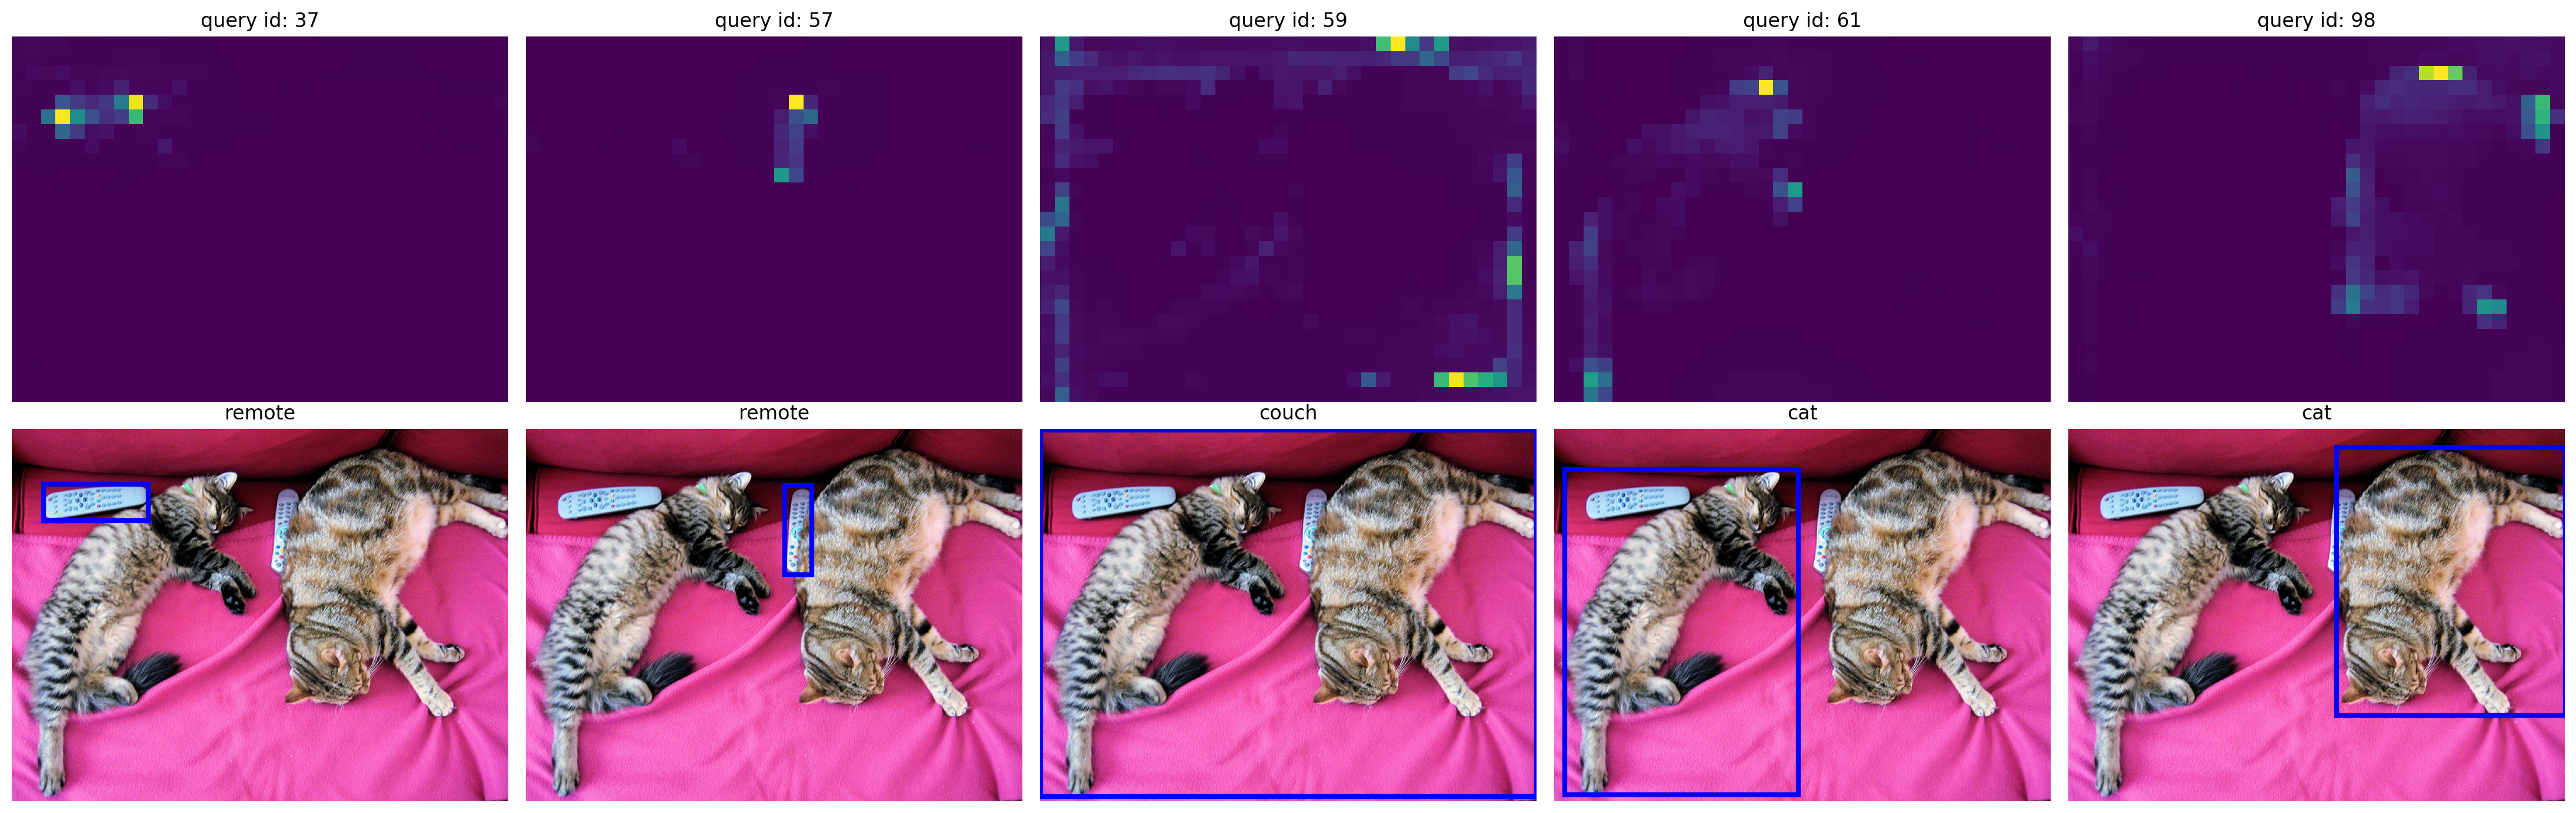

In [15]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    print(dec_attn_weights[0, idx].shape,h,w)
    ax.imshow(dec_attn_weights[0, idx].view(h, w))

    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

## Visualize encoder self-attention weights

In this section we visualize the model's self-attention. This allows us to gain intuition on how the model encodes the objects. In particular, we see from the attention response maps that the encoder already participate to the instance separation process.

Let's start by visualizing the shape of the encoder self-attention:

In [16]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([850, 850])
Feature map:             torch.Size([1, 2048, 25, 34])


As we can see, the self-attention is a square matrix of size `[H * W, H * W]`, where `H` and `W` are the sizes of the feature map, so we reshape it so that it has a more interpretable representation of `[H, W, H, W]`.

In [17]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 34, 25, 34])


In [25]:
shape+shape

torch.Size([25, 34, 25, 34])

Now that we have the self-attention into a more interpretable representation, let's try to visualize it.
Given that the self-attention is a very large matrix, let's start by selecting a few reference points where we will be looking at the attention.

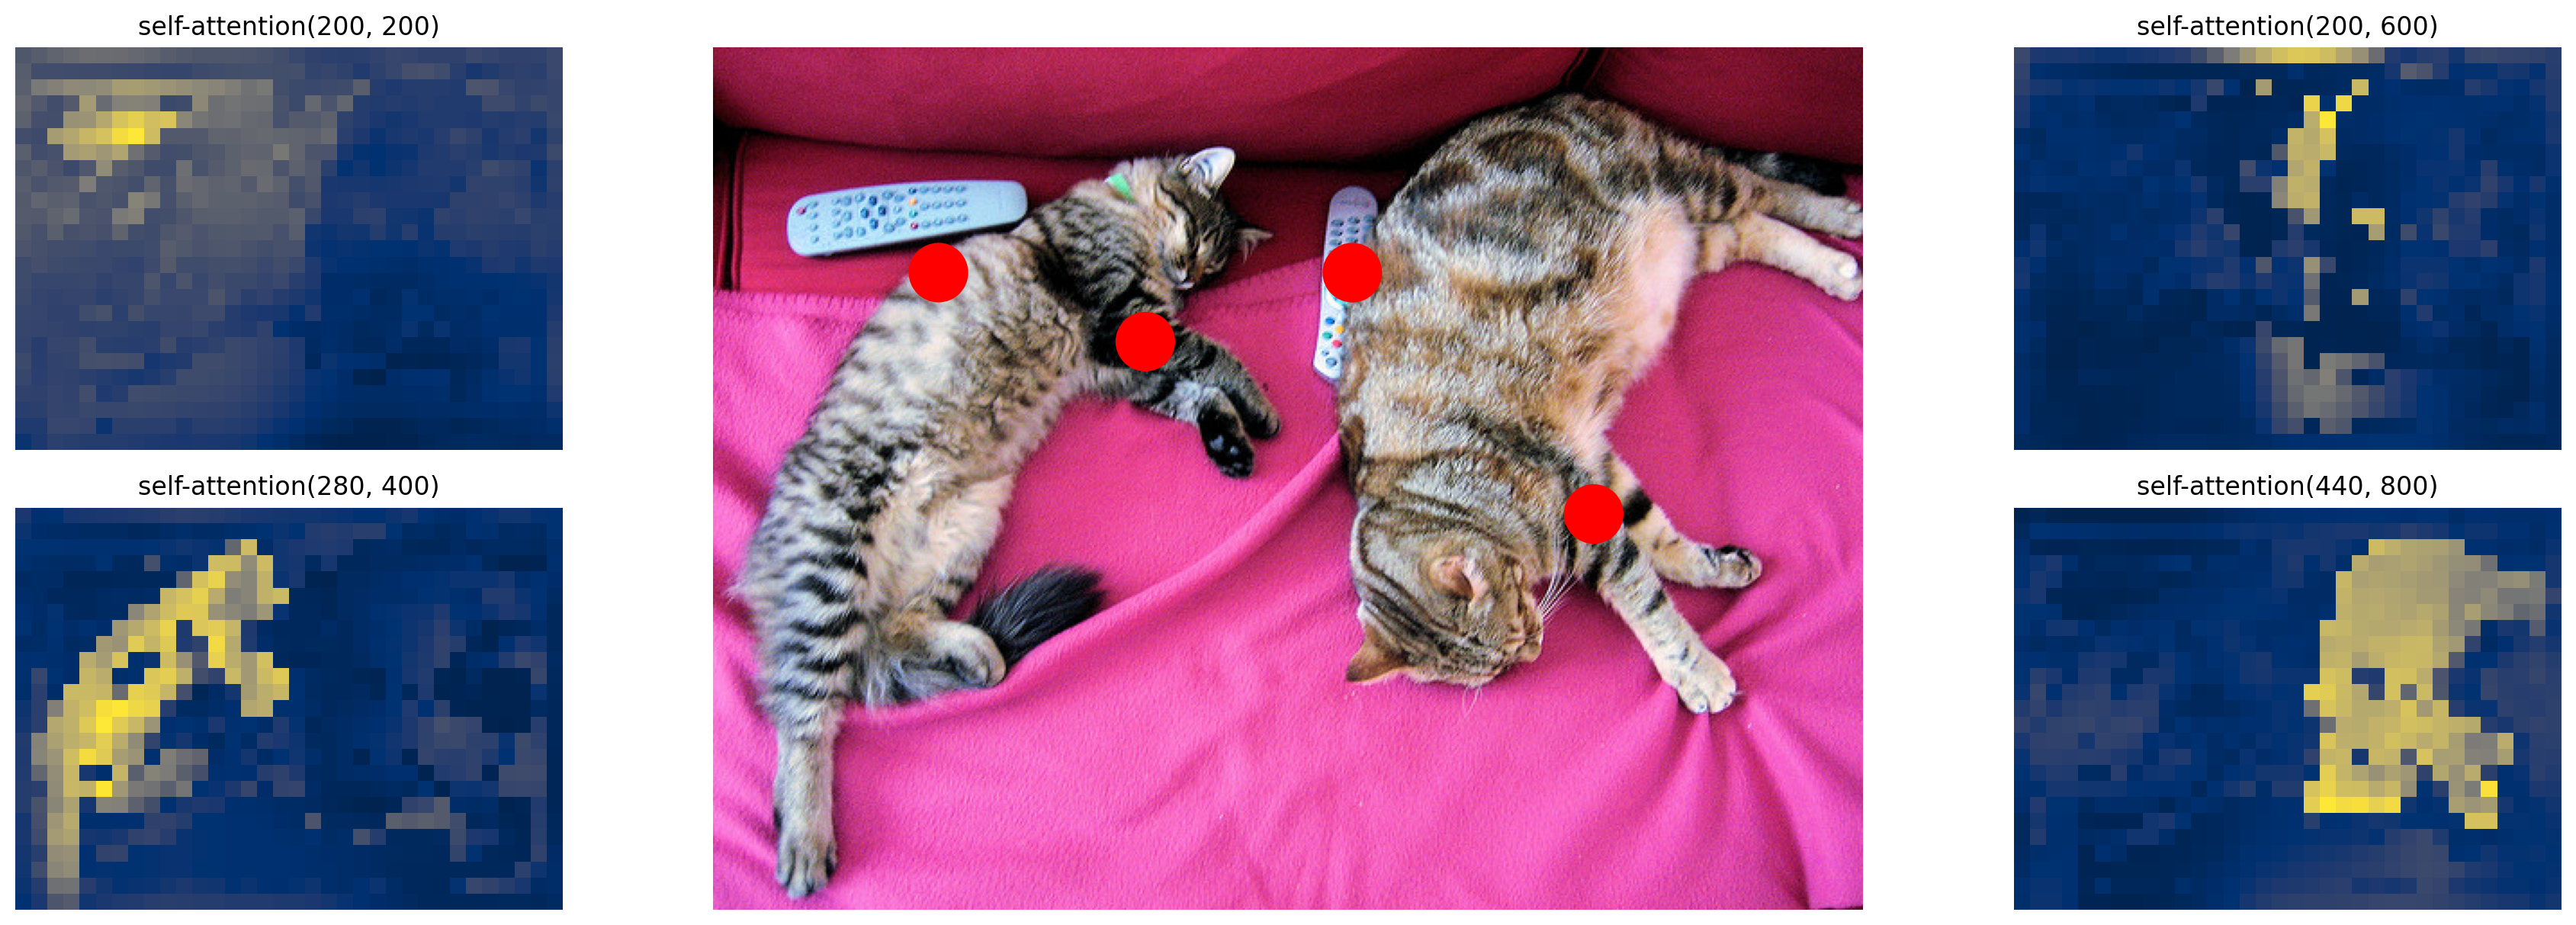

In [18]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

That's pretty nice! This visualization gives the intuition that the encoder might be already performing some sort of object separation thanks to the self-attention mechanism.


### Defining the AttentionVisualizer

There is a lot of code in there, but it's mostly boilerplate so that we can have a nice demo.
Ideally, we would have enabled a click-on-the-image to get the point we want to look at, but I couldn't make it work with Colab, so we used sliders instead.

You should execute the cell below, which is hidden in order to keep everything tidy, in order to get the `AttentionVisualizer` class that we will be using afterwards.

In [19]:
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='http://images.cocodataset.org/val2017/000000039769.jpg',
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # propagate through the model
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        # don't need the list anymore
        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        shape = self.conv_features['0'].tensors.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)

    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)

    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)

            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]

            axs[1].imshow(sattn_map, cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()

    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

### Using the AttentionVisualizer

Ok, phew, that was a lot of code, but how do we use it?
Just run the following cell, and it should work!

You can change the URL in the field, but don't forget to hit ENTER to submit it.
In the same way, we made the sliders only update its value once the user releases it, in order to avoid lags.

We additionally add two options for visualization:
- Direction of self-attention: the self-attention is a `[H, W, H, W]` matrix, so given a `i, j` point, we can return either `[i, j, :, :]` or `[:, :, i, j]`. This flag let's you chose how you want to visualize it
- Show red dot in attention: just adds a red dot to the self-attention image to facilitate visualization.

Give it a try!

In [20]:
w = AttentionVisualizer(model, transform)
w.run()

That's it! Now try it on your own image and see what the self-attention of the Transformer Encoder learned by itself!

##  Conclusion

In this notebook, we showed:
- how to use torchhub to compute predictions on your own image,
- how to visualize the decoder inter-attention for each prediction,
- how to visualize the encoder self-attention for a given reference point.

#Lab: Object Tracking

With bounding box detections, object tracking involves assigning the same ID to objects across consecutive frames, allowing us to follow their movements over time. One popular method for object tracking is the Simple Online and Real-time Tracking (SORT) algorithm, which can be installed using the pip package manager. The original research paper for SORT can be found at https://arxiv.org/abs/1602.00763.

SORT is a real-time tracking algorithm that efficiently handles multiple objects and maintains their identities over time. It combines the Kalman filter for object state prediction and the Hungarian algorithm for data association to match detections in consecutive frames. This allows it to accurately track objects even in complex scenarios with occlusions and appearance changes.

In [21]:
! pip -q install motrackers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.6 MB/s eta 0:00:00


## Traffic Speed from Cameras

One example application is to measure lane-specific individual vehicle speed using existing traffic monitoring cameras and computers. The method is reliable and cost-effective, supporting detailed safety analysis for traffic speed monitoring and traffic management. More details are here https://www.tandfonline.com/doi/full/10.1080/15389588.2023.2173522.

At TAMIDS, we also appliy this system to understand the fighting Texas Aggie Football Team home game traffic. The traffic count and speed can show conjestion and flow speed on a real-time map, valuable information to get around. You can find details here https://link.springer.com/article/10.1007/s43762-021-00031-w.


## Download Data

Let's first download a free-to-use example video, 10 seconds long. Colab is not easy to work with videos, especially displaying it. You do not have to worry about it on your local machine.

In [22]:
from IPython.display import HTML
from base64 import b64encode
video_path = 'Cars moving on road Stock Footage - Free Download.mp4'

mp4 = open(video_path,'rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=800 controls><source src={decoded_vid} type="video/mp4"></video>')

FileNotFoundError: [Errno 2] No such file or directory: 'Cars moving on road Stock Footage - Free Download.mp4'

## GPU

We need to push the model to GPU now because the video is large and we are taking the input of 800*800 pixel. You can change it in `Runtime`->`change runtime type`->`GPU`. Try CPU and GPU to see the difference.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
model.to(device)
model.eval();

## Make Prediction Function

When we define the prediction function, we are only interested in cars and trucks which are class number 3 and 8, and we ignore the rest. We also set the confidence threhold to 0.5.

In [ ]:
def predict(im):
    img = transform(im).unsqueeze(0).to(device)
    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.5+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.5

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    pil_img, prob, boxes=im, probas[keep], bboxes_scaled
    # print(prob)

    colors = COLORS * 100
    confs=[]
    bboxes=[]
    classes=[]
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):

        cl = p.argmax()
        if cl not in [3,8]:
            continue

        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'

        confs.append(p[p.argmax()].detach().cpu().numpy())
        bboxes.append([xmin, ymin, xmax, ymax])
        classes.append(cl.detach().cpu().numpy())

    return [confs,bboxes,classes]

### Two Frame Example

Randomly select frame 150 and 151 to make predictions and then apply Hungarian algorithm to match boxes in two seperate frames.  There is a useful online Hungarian matching calculator, check it out. https://www.hungarianalgorithm.com/solve.php

In [ ]:
import cv2

cap = cv2.VideoCapture('Cars moving on road Stock Footage - Free Download.mp4')
frame1=frame2=None

frame_number=0
while True:
    frame_number+=1
    ret, frame = cap.read()  # frame shape 640*480*3
    if ret != True:
        break
    if frame_number==150:
        frame1=frame.copy()

    if frame_number==151:
        frame2=frame.copy()

Showing frame1 and frame2 with prediction boxes with confidences. We will use the boxes to assign IDs.

In [ ]:
frame=frame1
img_raw = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img_raw = Image.fromarray(img_raw)
# run inference
detection_confidences ,bboxes_scaled , detection_class_ids = predict(img_raw)
boxes1=bboxes_scaled
for c,bbox,cl in zip(detection_confidences ,bboxes_scaled , detection_class_ids):
    # print(bbox)
    x1,y1,x2,y2 = bbox
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 3)
    text = f'{CLASSES[cl]}: {c:0.2f}'
    cv2.putText(frame,text,(int(x1), int(y1+20)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)
plt.imshow(frame[:,:,::-1])

In [ ]:
frame=frame2
img_raw = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img_raw = Image.fromarray(img_raw)
# run inference
detection_confidences ,bboxes_scaled , detection_class_ids = predict(img_raw)
boxes2=bboxes_scaled
for c,bbox,cl in zip(detection_confidences ,bboxes_scaled , detection_class_ids):
    # print(bbox)
    x1,y1,x2,y2 = bbox
    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 3)
    text = f'{CLASSES[cl]}: {c:0.2f}'
    cv2.putText(frame,text,(int(x1), int(y1+20)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)
plt.imshow(frame[:,:,::-1])

In [ ]:
frame.shape

Becuase these two frame are not the same, we plot all the boxes on a blank canvas to show the comparison. Each list of boxes is assigned a list of ID: numbers and letters. Here, we assume the numbered boxes are in the first frame and the following frame has lettered boxes.

In [ ]:
import cv2
import numpy as np
import string
alphabet = list(string.ascii_uppercase)

def plot_boxes_on_blank_canvas(boxes_list1, boxes_list2, canvas_size=(frame.shape[0], frame.shape[1]), color1=(255, 0, 0), color2=(0, 255, 255)):
    # Create a blank canvas as a NumPy array
    canvas = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)  # Black canvas

    # Draw boxes from the first list with color1
    for i,bbox in enumerate(boxes_list1):

        x1,y1,x2,y2 = bbox
        cv2.rectangle(canvas, (int(x1), int(y1)), (int(x2), int(y2)), color1, thickness=5)
        cv2.putText(canvas,str(i),(int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 2, color1, 2)
    # Draw boxes from the second list with color2
    for i,bbox in enumerate(boxes_list2):
        x1,y1,x2,y2 = bbox
        cv2.rectangle(canvas, (int(x1), int(y1)), (int(x2), int(y2)), color2, thickness=5)
        cv2.putText(canvas,alphabet[i],(int(x1), int(y2)), cv2.FONT_HERSHEY_SIMPLEX, 2, color2, 2)
    # Show the canvas with the plotted boxes
    plt.imshow(canvas)

# Example usage
# boxes_list1 = [[10, 20, 40, 50], [60, 30, 80, 70]]
# boxes_list2 = [[25, 35, 50, 60], [70, 40, 90, 80]]
# plot_boxes_on_blank_canvas(boxes_list1, boxes_list2)
plot_boxes_on_blank_canvas(boxes1, boxes2)


We can see just in two frames, the cars move considerable distance. For the best tracking results, we should not skip frames. Human eyes do not necessarily catch this difference.

Next, we calculate the IoU for all possible pair for all boxes, resulting in a cost matrix. Note here IoU = 1 means the best result and 0 means no overlap. We want the opposite case to build the cost matrix so we can minimize the cost.

In [ ]:
import numpy as np

def calculate_iou(box1, box2):
    # Calculate the intersection area
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Calculate the union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Calculate the IOU
    iou = intersection_area / union_area
    return iou

def compute_cost_matrix(boxes_list1, boxes_list2):
    cost_matrix = np.zeros((len(boxes_list1), len(boxes_list2)))

    for i, box1 in enumerate(boxes_list1):
        for j, box2 in enumerate(boxes_list2):
            cost_matrix[i, j] = 1 - calculate_iou(box1, box2)

    return cost_matrix

# Example usage
# boxes_list1 = [[10, 20, 40, 50], [60, 30, 80, 70]]
# boxes_list2 = [[25, 35, 50, 60], [70, 40, 90, 80]]
cost_matrix = compute_cost_matrix(boxes1, boxes2)


In [ ]:
len(boxes1)

Putting the cost matrix in a panda frame to see better.

In [ ]:
import pandas as pd
pd.DataFrame(cost_matrix)


## Hungarian Matching

Here function `linear_sum_assignment` returns the row and column index with the lowest cost one-on-one matching. We can print out the results and see if they actually match the correct boxes. Go back and look at the visualization and verify.

In [ ]:
from scipy.optimize import linear_sum_assignment

row_indices, col_indices = linear_sum_assignment(cost_matrix)

for row, col in zip(row_indices, col_indices):

    print("frame1 point {} match frame2 point {}".format(row,alphabet[col]))


## Put Together

The Simple Online and Real-time Tracking (SORT) algorithm builds on top of the Hungarian algorithm and incorporates additional features like the Kalman filter to enhance its robustness in tracking objects.

The Kalman filter is a mathematical tool used to predict an object's future state based on its current state and previous observations. In the context of object tracking, the Kalman filter is used to estimate the object's position and velocity over time, helping to smooth out noisy detections and make more accurate predictions.


In [ ]:
from motrackers import CentroidTracker, CentroidKF_Tracker, SORT, IOUTracker
from motrackers.utils import draw_tracks
# def get_trace(file_path):
video_capture = cv2.VideoCapture(file_path)
width = int(video_capture.get(3))
height = int(video_capture.get(4))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter(file_path[:-4]+'_DETR_SORT.mp4', fourcc, fps, (width, height))

tracker = SORT()

# tracker = CentroidTracker(max_lost=fps)

data={}
frame_data={}

frame_number=0
while True:
    frame_number+=1
    ret, frame = video_capture.read()  # frame shape 640*480*3
    if ret != True:
        break
    img_raw = frame.copy()
    img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    # cv2.resize(img_raw, (width*2,height*2), interpolation=cv2.INTER_LINEAR)
    img_raw = Image.fromarray(img_raw)
    # run inference
    detection_confidences ,bboxes_scaled , detection_class_ids = predict(img_raw)
    # if len(bboxes_scaled)==0:continue
    detection_bboxes = [[x1,y1,x2-x1,y2-y1] for [x1,y1,x2,y2] in bboxes_scaled]
    tracks = tracker.update(np.array(detection_bboxes), detection_confidences, detection_class_ids)

    # draw the predictions
    # bboxes_scaled = predict(img_raw)
    # bboxes_scaled=detection_bboxes
    for c,bbox,cl in zip(detection_confidences ,bboxes_scaled , detection_class_ids):
        # print(bbox)
        x1,y1,x2,y2 = bbox
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 3)
        text = f'{CLASSES[cl]}: {c:0.2f}'
        cv2.putText(frame,text,(int(x1), int(y1+20)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

    for t in tracks:
        frame_numeber=t[0]
        ID = t[1]
        xmin,ymin,w,h = t[2:6]
        xcentroid, ycentroid = int(xmin + 0.5*w), int(ymin + 0.5*h)
        if ID in data.keys():
            data[ID].append([xcentroid, ycentroid,frame_number])
        else:
            data.update({ID:[]})
            data[ID].append([xcentroid, ycentroid,frame_number])

    updated_image = draw_tracks(frame, tracks)
    print(frame_number,end=',')
    updated_image =  cv2.resize(updated_image, (width,height),interpolation=cv2.INTER_AREA)
    # cv2.imshow("Out",updated_image)
    out.write(updated_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
out.release()
cv2.destroyAllWindows()
np.save(file_path[:-4]+'.npy',data)

We can load the see the video tracking results just like how we displayed the video. But before we load, we need to convert the output video to H.264 format. This is to play videos on the web browser, not all mp4 files are compatible with browsers. Do not worry much about the video display.

In [ ]:
! ffmpeg -i "Cars moving on road Stock Footage - Free Download_DETR_SORT.mp4" -vcodec libx264 -f mp4 output.mp4 -hide_banner

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width=800 controls><source src={decoded_vid} type="video/mp4"></video>')

We can see that the cars are marked with unique ID through out the 10 second video. By defining the physical distance between two lines, and the FPS of the video, we can measure the rough speed of each vehicle.


After the camera angle increases, we can see many small objects detected in the background and not all of them are TPs. Small object detection a big challenge  because the limited pixel input signals.

## Summary

In this lab, we used Hungarian algorithm to associate two lists of boxes in consequtive frames to assign unique IDs. The resulting traces are valuable information for many downstream tasks. Hangarian matching is also useful to match the prediction and grountruth boxes in object detection training in DETR.